<a href="https://colab.research.google.com/github/As2909/Pytorch-Zero-To-Mastery/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Tue Jul 23 07:10:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.1+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Use more Hidden layers
2. Change activation function
3. Incresing th epochs




## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
## Remove the zip file after extracting.
! rm -r data/pizza_steak_sushi.zip

In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path/ "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

sushi
Random image path: data/pizza_steak_sushi/test/sushi/1172255.jpg
Image class: sushi
Image height: 383
Image width: 512


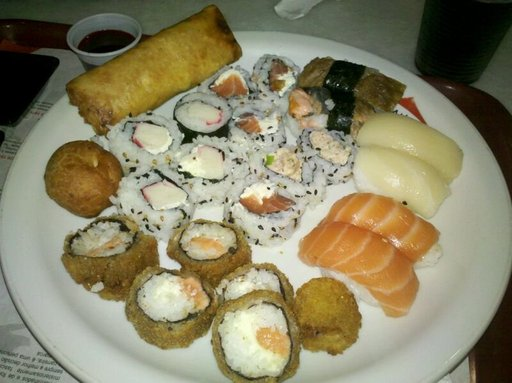

In [8]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_img = random.choice(image_path_list)

image_class = random_img.parent.stem
print(image_class)

img = Image.open(random_img)
# Print metadata
print(f"Random image path: {random_img}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

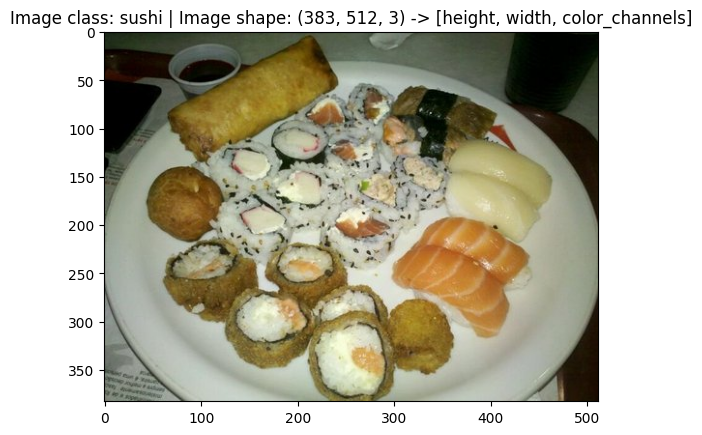

In [9]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt

img = plt.imread(random_img)
plt.title(f"Image class: {image_class} | Image shape: {img.shape} -> [height, width, color_channels]")
plt.imshow(img)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [10]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [11]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=((64, 64))),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

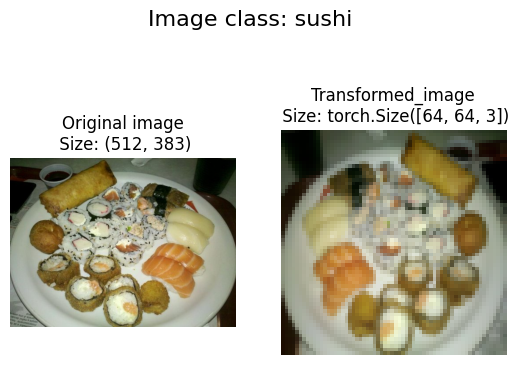

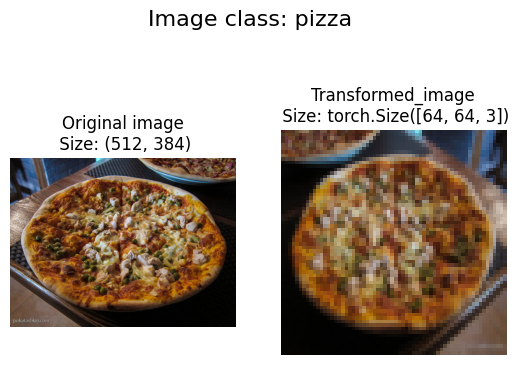

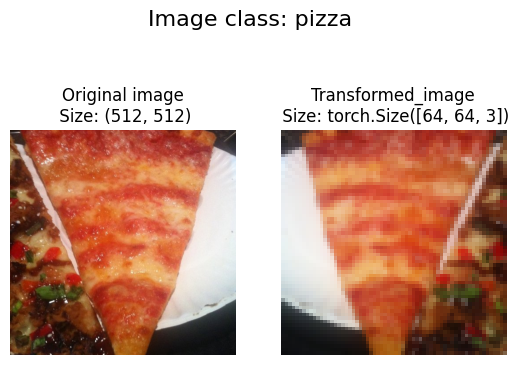

In [12]:
# Write a function to plot transformed images
def plot_transformed_image(image_path, transforms, n, seed=42):
  random.seed(seed)

  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image\n Size: {f.size}")
      ax[0].axis("off")

      transformed_image = transforms(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed_image\n Size: {transformed_image.shape}")
      ax[1].axis("off")

    plt.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)

plot_transformed_image(image_path_list, data_transform, n=3)

### Load image data using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f86ecc1d1e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f86ecc61090>)

In [18]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
img, label = next(iter(train_dataloader))
img.shape, label.item()

(torch.Size([1, 3, 64, 64]), 2)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [27]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16, out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


In [28]:
model_0 = TinyVGG(input_shape = 3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [29]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X_train, y_train) in enumerate(train_dataloader):
    # Send data to target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # 1. Forward pass
    y_pred = model(X_train)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y_train).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)
  return train_loss , train_acc

In [30]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Send data to target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred_logits = model(X_test)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y_test)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y_test).sum().item() / len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/ len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  return test_loss, test_acc

In [31]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [34]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3378 | test_loss: 1.1021 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0994 | train_acc: 0.3200 | test_loss: 1.1024 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3333 | test_loss: 1.1024 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.2933 | test_loss: 1.1022 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.1019 | test_acc: 0.3333


{'train_loss': [1.103270373079512,
  1.0993930599424575,
  1.0990990214877658,
  1.09883407274882,
  1.0989658726586236],
 'train_acc': [0.3377777777777778,
  0.32,
  0.3333333333333333,
  0.29333333333333333,
  0.32],
 'test_loss': [1.1021106656392414,
  1.1024083312352497,
  1.102398689587911,
  1.1021806621551513,
  1.101876252492269],
 'test_acc': [0.25333333333333335,
  0.25333333333333335,
  0.25333333333333335,
  0.3333333333333333,
  0.3333333333333333]}

In [35]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1004 | train_acc: 0.3244 | test_loss: 1.0963 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1094 | train_acc: 0.3644 | test_loss: 1.1009 | test_acc: 0.3200
Epoch: 3 | train_loss: 1.0936 | train_acc: 0.3867 | test_loss: 1.0938 | test_acc: 0.4267
Epoch: 4 | train_loss: 1.0058 | train_acc: 0.5689 | test_loss: 0.9927 | test_acc: 0.4267
Epoch: 5 | train_loss: 0.9256 | train_acc: 0.5956 | test_loss: 0.9669 | test_acc: 0.5200
Epoch: 6 | train_loss: 0.8662 | train_acc: 0.6133 | test_loss: 0.9906 | test_acc: 0.4400
Epoch: 7 | train_loss: 0.8349 | train_acc: 0.6222 | test_loss: 1.0405 | test_acc: 0.4000
Epoch: 8 | train_loss: 0.7721 | train_acc: 0.6667 | test_loss: 1.1906 | test_acc: 0.4267
Epoch: 9 | train_loss: 0.7649 | train_acc: 0.6978 | test_loss: 1.0579 | test_acc: 0.4800
Epoch: 10 | train_loss: 0.6655 | train_acc: 0.6933 | test_loss: 1.0747 | test_acc: 0.5200
Epoch: 11 | train_loss: 0.6284 | train_acc: 0.7333 | test_loss: 1.0849 | test_acc: 0.5067
Epoch: 12 | train_l

{'train_loss': [1.100370803144243,
  1.1093538663122389,
  1.0936140722698635,
  1.0058313209149572,
  0.9255733871335785,
  0.8662037021335628,
  0.8349158941002356,
  0.7721205176640716,
  0.764893083481325,
  0.665456135161221,
  0.6283986396001031,
  0.5663133075093436,
  0.5644675463084907,
  0.4694227045620533,
  0.46500784875618084,
  0.41138536474023973,
  0.3361496367132188,
  0.3436969381686504,
  0.27176699738534654,
  0.24807635840738765],
 'train_acc': [0.3244444444444444,
  0.36444444444444446,
  0.38666666666666666,
  0.5688888888888889,
  0.5955555555555555,
  0.6133333333333333,
  0.6222222222222222,
  0.6666666666666666,
  0.6977777777777778,
  0.6933333333333334,
  0.7333333333333333,
  0.7644444444444445,
  0.7866666666666666,
  0.8266666666666667,
  0.8,
  0.8488888888888889,
  0.8977777777777778,
  0.8666666666666667,
  0.9288888888888889,
  0.9066666666666666],
 'test_loss': [1.0962551546096801,
  1.10086043993632,
  1.0937828167279562,
  0.9926509614785513,
  0.

In [36]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2064 | train_acc: 0.9422 | test_loss: 1.8297 | test_acc: 0.5467
Epoch: 2 | train_loss: 0.2264 | train_acc: 0.9067 | test_loss: 1.9491 | test_acc: 0.5600
Epoch: 3 | train_loss: 0.2216 | train_acc: 0.9156 | test_loss: 2.0288 | test_acc: 0.4933
Epoch: 4 | train_loss: 0.1491 | train_acc: 0.9556 | test_loss: 2.3359 | test_acc: 0.4933
Epoch: 5 | train_loss: 0.1154 | train_acc: 0.9644 | test_loss: 2.7258 | test_acc: 0.4800
Epoch: 6 | train_loss: 0.0989 | train_acc: 0.9778 | test_loss: 2.5600 | test_acc: 0.5200
Epoch: 7 | train_loss: 0.1015 | train_acc: 0.9600 | test_loss: 2.0713 | test_acc: 0.5867
Epoch: 8 | train_loss: 0.0859 | train_acc: 0.9689 | test_loss: 3.2603 | test_acc: 0.5467
Epoch: 9 | train_loss: 0.1718 | train_acc: 0.9244 | test_loss: 2.5346 | test_acc: 0.4933
Epoch: 10 | train_loss: 0.0784 | train_acc: 0.9822 | test_loss: 2.9219 | test_acc: 0.4933
Epoch: 11 | train_loss: 0.0555 | train_acc: 0.9867 | test_loss: 3.0375 | test_acc: 0.5200
Epoch: 12 | train_l

{'train_loss': [0.20642459717653838,
  0.2263827101644253,
  0.22158228883167988,
  0.14909846524081138,
  0.1154415609907692,
  0.09889749873049175,
  0.1014500317959278,
  0.08591555696446228,
  0.1718035175869976,
  0.07837599887443099,
  0.05549742843216595,
  0.0634307052347169,
  0.08495516455588721,
  0.060033715371735956,
  0.15521579061122137,
  0.06188019740284223,
  0.026672163867226668,
  0.022643785506291148,
  0.01592192168294313,
  0.013876921947391388,
  0.020229351012295702,
  0.013191720578157628,
  0.0073191266450569024,
  0.0050480609248095085,
  0.008082845521151903,
  0.13293999211203725,
  0.2962511637742549,
  0.08486364955992268,
  0.05502503622531805,
  0.018157511049134628,
  0.007438708149245643,
  0.003958508955282759,
  0.0037327822973071217,
  0.0037438149441034498,
  0.002689170174043246,
  0.001967487685628997,
  0.0019014694554005335,
  0.0014828390581574367,
  0.0027431355126563517,
  0.001124810846626916,
  0.0011539922084956957,
  0.0009870578822910

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [39]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape = 3, hidden_units=20, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.001)
train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1010 | train_acc: 0.3644 | test_loss: 1.0910 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1020 | train_acc: 0.3600 | test_loss: 1.0776 | test_acc: 0.3200
Epoch: 3 | train_loss: 1.0926 | train_acc: 0.3156 | test_loss: 1.0988 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3244 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.1078 | train_acc: 0.3244 | test_loss: 1.1658 | test_acc: 0.4133
Epoch: 6 | train_loss: 1.0516 | train_acc: 0.4889 | test_loss: 1.0571 | test_acc: 0.3733
Epoch: 7 | train_loss: 1.0243 | train_acc: 0.5600 | test_loss: 1.0270 | test_acc: 0.4000
Epoch: 8 | train_loss: 0.9545 | train_acc: 0.6133 | test_loss: 0.9869 | test_acc: 0.5200
Epoch: 9 | train_loss: 0.9058 | train_acc: 0.5911 | test_loss: 1.0097 | test_acc: 0.4667
Epoch: 10 | train_loss: 0.8628 | train_acc: 0.6222 | test_loss: 1.0749 | test_acc: 0.3733
Epoch: 11 | train_loss: 0.8560 | train_acc: 0.6400 | test_loss: 1.0030 | test_acc: 0.4133
Epoch: 12 | train_l

{'train_loss': [1.101036401854621,
  1.101951647069719,
  1.0925667312410143,
  1.0990246894624498,
  1.1078088914023505,
  1.0515802220006785,
  1.024265391073293,
  0.9544510071807437,
  0.9057894749132296,
  0.8627866847668257,
  0.855990972129835,
  0.7735054754962524,
  0.7604776702076197,
  0.6801911308890622,
  0.6751668011986961,
  0.6214787139933712,
  0.5852804513949539,
  0.5347481288504787,
  0.5036055285200322,
  0.4446805996639321],
 'train_acc': [0.36444444444444446,
  0.36,
  0.31555555555555553,
  0.3244444444444444,
  0.3244444444444444,
  0.4888888888888889,
  0.56,
  0.6133333333333333,
  0.5911111111111111,
  0.6222222222222222,
  0.64,
  0.6844444444444444,
  0.6444444444444445,
  0.6977777777777778,
  0.7333333333333333,
  0.7244444444444444,
  0.7422222222222222,
  0.7688888888888888,
  0.7822222222222223,
  0.8088888888888889],
 'test_loss': [1.0909570487340292,
  1.077618134021759,
  1.0988257455825805,
  1.0998965454101564,
  1.1657900742689769,
  1.057111435

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [40]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [41]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images...

In [42]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [43]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data = ImageFolder(
    root=train_data_20_percent_path,
    transform=simple_transform)

test_data = ImageFolder(
    root=test_data_20_percent_path,
    transform=simple_transform)

# Create dataloaders
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 1,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 1,
    shuffle = False
)

train_dataloader ,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8705ab9a20>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8705ab9d80>)

In [44]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [46]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

train(
    model=model_2,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1060 | train_acc: 0.3467 | test_loss: 1.0985 | test_acc: 0.3533
Epoch: 2 | train_loss: 1.0993 | train_acc: 0.2911 | test_loss: 1.0987 | test_acc: 0.3067
Epoch: 3 | train_loss: 1.1012 | train_acc: 0.3422 | test_loss: 1.0981 | test_acc: 0.3067
Epoch: 4 | train_loss: 1.0470 | train_acc: 0.4844 | test_loss: 0.9102 | test_acc: 0.6400
Epoch: 5 | train_loss: 0.9311 | train_acc: 0.5778 | test_loss: 1.0849 | test_acc: 0.4133
Epoch: 6 | train_loss: 0.9165 | train_acc: 0.5556 | test_loss: 0.8733 | test_acc: 0.5867
Epoch: 7 | train_loss: 0.8644 | train_acc: 0.6022 | test_loss: 0.8730 | test_acc: 0.6000
Epoch: 8 | train_loss: 0.8275 | train_acc: 0.6289 | test_loss: 0.8723 | test_acc: 0.6067
Epoch: 9 | train_loss: 0.7801 | train_acc: 0.6578 | test_loss: 0.9108 | test_acc: 0.5333
Epoch: 10 | train_loss: 0.7472 | train_acc: 0.6689 | test_loss: 0.9449 | test_acc: 0.5400
Epoch: 11 | train_loss: 0.6550 | train_acc: 0.7333 | test_loss: 0.9597 | test_acc: 0.5267
Epoch: 12 | train_l

{'train_loss': [1.1059908640384675,
  1.099301020304362,
  1.101241834031211,
  1.0470049648483595,
  0.9311135392718844,
  0.9165196532300777,
  0.8643918558085958,
  0.8274640111801111,
  0.7800843559464232,
  0.7472309167776257,
  0.6549593810191274,
  0.5520276011787225,
  0.4488602090125318,
  0.34265755232054484,
  0.2882287876767269,
  0.2085366909266162,
  0.12740882870043205,
  0.12497932394531702,
  0.10260016789648238,
  0.055683045238834536],
 'train_acc': [0.3466666666666667,
  0.2911111111111111,
  0.3422222222222222,
  0.48444444444444446,
  0.5777777777777777,
  0.5555555555555556,
  0.6022222222222222,
  0.6288888888888889,
  0.6577777777777778,
  0.6688888888888889,
  0.7333333333333333,
  0.7844444444444445,
  0.8155555555555556,
  0.8777777777777778,
  0.8866666666666667,
  0.9111111111111111,
  0.96,
  0.96,
  0.9644444444444444,
  0.9866666666666667],
 'test_loss': [1.0984863495826722,
  1.098707026640574,
  1.0980581990877787,
  0.9102292048434416,
  1.0849073290

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

Model is still overfitting the data.\
We need to further investigating or try the different method to reduce overfitting  

In [54]:
img = "pizza.jpg"

with open(img, "wb") as f:
  request = requests.get("https://t3.ftcdn.net/jpg/00/27/57/96/360_F_27579652_tM7V4fZBBw8RLmZo0Bi8WhtO2EosTRFD.jpg")
  f.write(request.content)

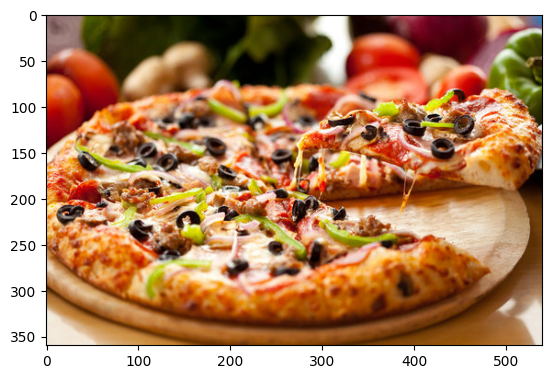

In [55]:
import matplotlib.pyplot as plt
custom_img = plt.imread("pizza.jpg")
plt.imshow(custom_img)

In [60]:
import torchvision

img = torchvision.io.read_image("pizza.jpg")
img.shape

torch.Size([3, 360, 540])

Text(0.5, 1.0, 'Pred label: pizza')

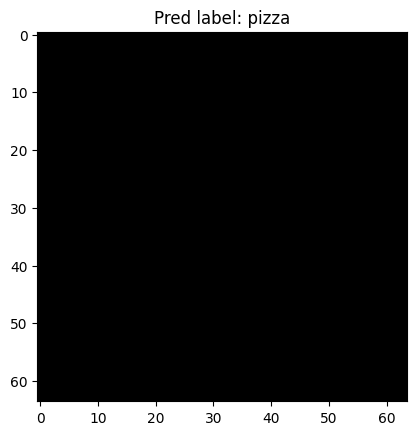

In [64]:
# Make a prediction on the image
model_2.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_2(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
